In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import numpy as np

Imagine that you want to test whether consumers can learn a given distribution and reproduce it on a distribution builder. 

Specifically, you want to test if participants can learn a normal distribution with parameters $\mu = 25$ and $\sigma = 5$.

For the sake of illustration, let's assume the following:
* Each participant will learn 50 numbers
* You want those 50 numbers to be integer (to facilitate learning) will only present integers from this distribution.
* You want participants to report the numbers that they have seen on a distribution builder with 25 bins, from 0 to 50, in increments of 2.

How to create distribution of 50 integers that will match a normal distribution $\mathcal{N}(\mu, \sigma)$?

## A bad solution: the "random draw" approach

It might seem obvious: let's just draw those numbers from the distribution!

In [10]:
np.random.seed(25330)
MU = 25
SIGMA = 5
N = 50
BINS = np.arange(1, 51.5, 2)
numbers = np.random.normal(MU, SIGMA, size=N) # Random draw of 50 numbers
round_numbers = np.round(numbers, 0) # Rounded to nearest integet

When we visualize it however....

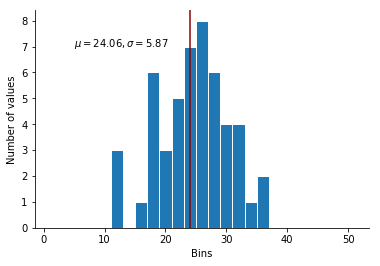

In [11]:
plt.hist(round_numbers, bins=BINS, ec="white", align="mid");
plt.axvline(np.mean(round_numbers),color="darkred")
plt.annotate(r"$\mu = {:.2f}, \sigma = {:.2f}$".format(round_numbers.mean(), round_numbers.std()),(5, 7))
plt.ylabel("Number of values")
plt.xlabel("Bins")
sns.despine();

The mean is lower than what we'd like, the standard deviation is too high, and the distribution would not look normal at all when reported in a distribution builder. 

This was expected: random numbers are, by definition, random. Can we do better?


## A slightly better approach: the iterative approach

Yes! We could repeated this sampling process several times, until we are sufficiently close to the parameters of the distribution that we want to obtain.

In [12]:
ERR_MU = 0.01
ERR_SIGMA = 0.1
SKEW_SIGMA = 0.01
numbers = np.random.normal(MU, SIGMA, size=N)
round_numbers = np.round(numbers, 0)
m = numbers.mean()
sd = numbers.std()
skew = stats.skew(numbers)
i = 1
while (np.abs(m-MU) > ERR_MU) or (np.abs(sd-SIGMA) > ERR_SIGMA) or (np.abs(skew) > SKEW_SIGMA):
    i += 1
    numbers = np.random.normal(MU, SIGMA, size=N)
    round_numbers = np.round(numbers, 0)
    m = numbers.mean()
    sd = numbers.std()
    skew = stats.skew(numbers)
print("After {} iterations, we have a satisfying distribution".format(i))

After 6902 iterations, we have a satisfying distribution


That took a few seconds. Let's visualize it...

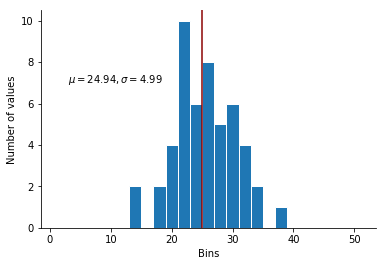

In [13]:
plt.hist(round_numbers, bins=BINS, ec="white", align="mid")
plt.axvline(np.mean(round_numbers), color="darkred")
plt.annotate(r"$\mu = {:.2f}, \sigma = {:.2f}$".format(round_numbers.mean(), round_numbers.std()),(3, 7))
plt.ylabel("Number of values")
plt.xlabel("Bins")
sns.despine();

The distribution now has the mean, variance and skew that we want... But it still not perfectly normal. In particular, the mode does not correspond to the mean... Do we really want to give reviewer B something to nitpick about?

## The correct method: binning a continuous distribution

The trick is to follow these steps:
1. Obtain the CDF of the distribution that we want to copy (here the CDF of $\mathcal{N}(25, 5)$
2. Use this CDF to compute the probability of each random value falling in each bucket of the distribution builder. Formally, we compute for each bucket $P(l \leq X \leq h)$, where $l$ and $h$ are the lower and upper bounds of each bucket.
3. Convert those probabilities in a number of observations, rounding them to the nearest integer.
4. If this creates less observations than what we want, increase the probability of each observation by a very small amount.

Putting this together into a function:

In [14]:
def bin_dist(dist, buckets, n):
    """
    Generate a discrete distribution of numbers that match a target distribution.
    dist: 
        The Distribution object from which the CDF will be computed. 
        Can be any distribution, as long as it has support on the `buckets` provided
    buckets: 
        The buckets of the distribution builder that will be used
    n: 
        The number of observations that should be presented.
        
    Returns:
        An array of length n containing the values.
    """
    spacing = (buckets[1]-buckets[0])/2 # Space between each of the buckets
    lbounds = buckets-spacing # Lower bound of each bucket
    rbounds = buckets + spacing # Upper bound
    lcdf = dist.cdf(lbounds) # CDF up to lower bound
    rcdf = dist.cdf(rbounds) # CDF up to upper bound
    p = rcdf-lcdf # Probability of value being in the bucket
    nballs = np.round(p*n, 0) # Multiplying by expected number of values, and rounding to nearest integer
    mult = 1
    while (nballs.sum() < n): # In case we don't have enough observations...
        mult += 0.05
        nballs = np.round(p*n*mult)
    return np.repeat(buckets, nballs.astype(int))

Now if we apply this method:

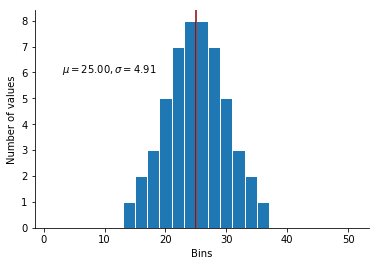

In [15]:
dist = stats.norm(MU, SIGMA)
round_numbers = bin_dist(dist, np.arange(0, 51, 2), 50)
plt.hist(round_numbers, bins=BINS, align="mid", ec="white")
plt.axvline(np.mean(round_numbers), color="darkred")
plt.annotate(r"$\mu = {:.2f}, \sigma = {:.2f}$".format(round_numbers.mean(), round_numbers.std()),(3, 6))
plt.ylabel("Number of values")
plt.xlabel("Bins")
sns.despine();

This is exactly what we want ! A normal-like distribution of integers.

This method is also very flexible: it can be applied to any continuous distribution and any number of buckets. 

Here are a few illustrations of the function for different distributions, varying the number of buckets.

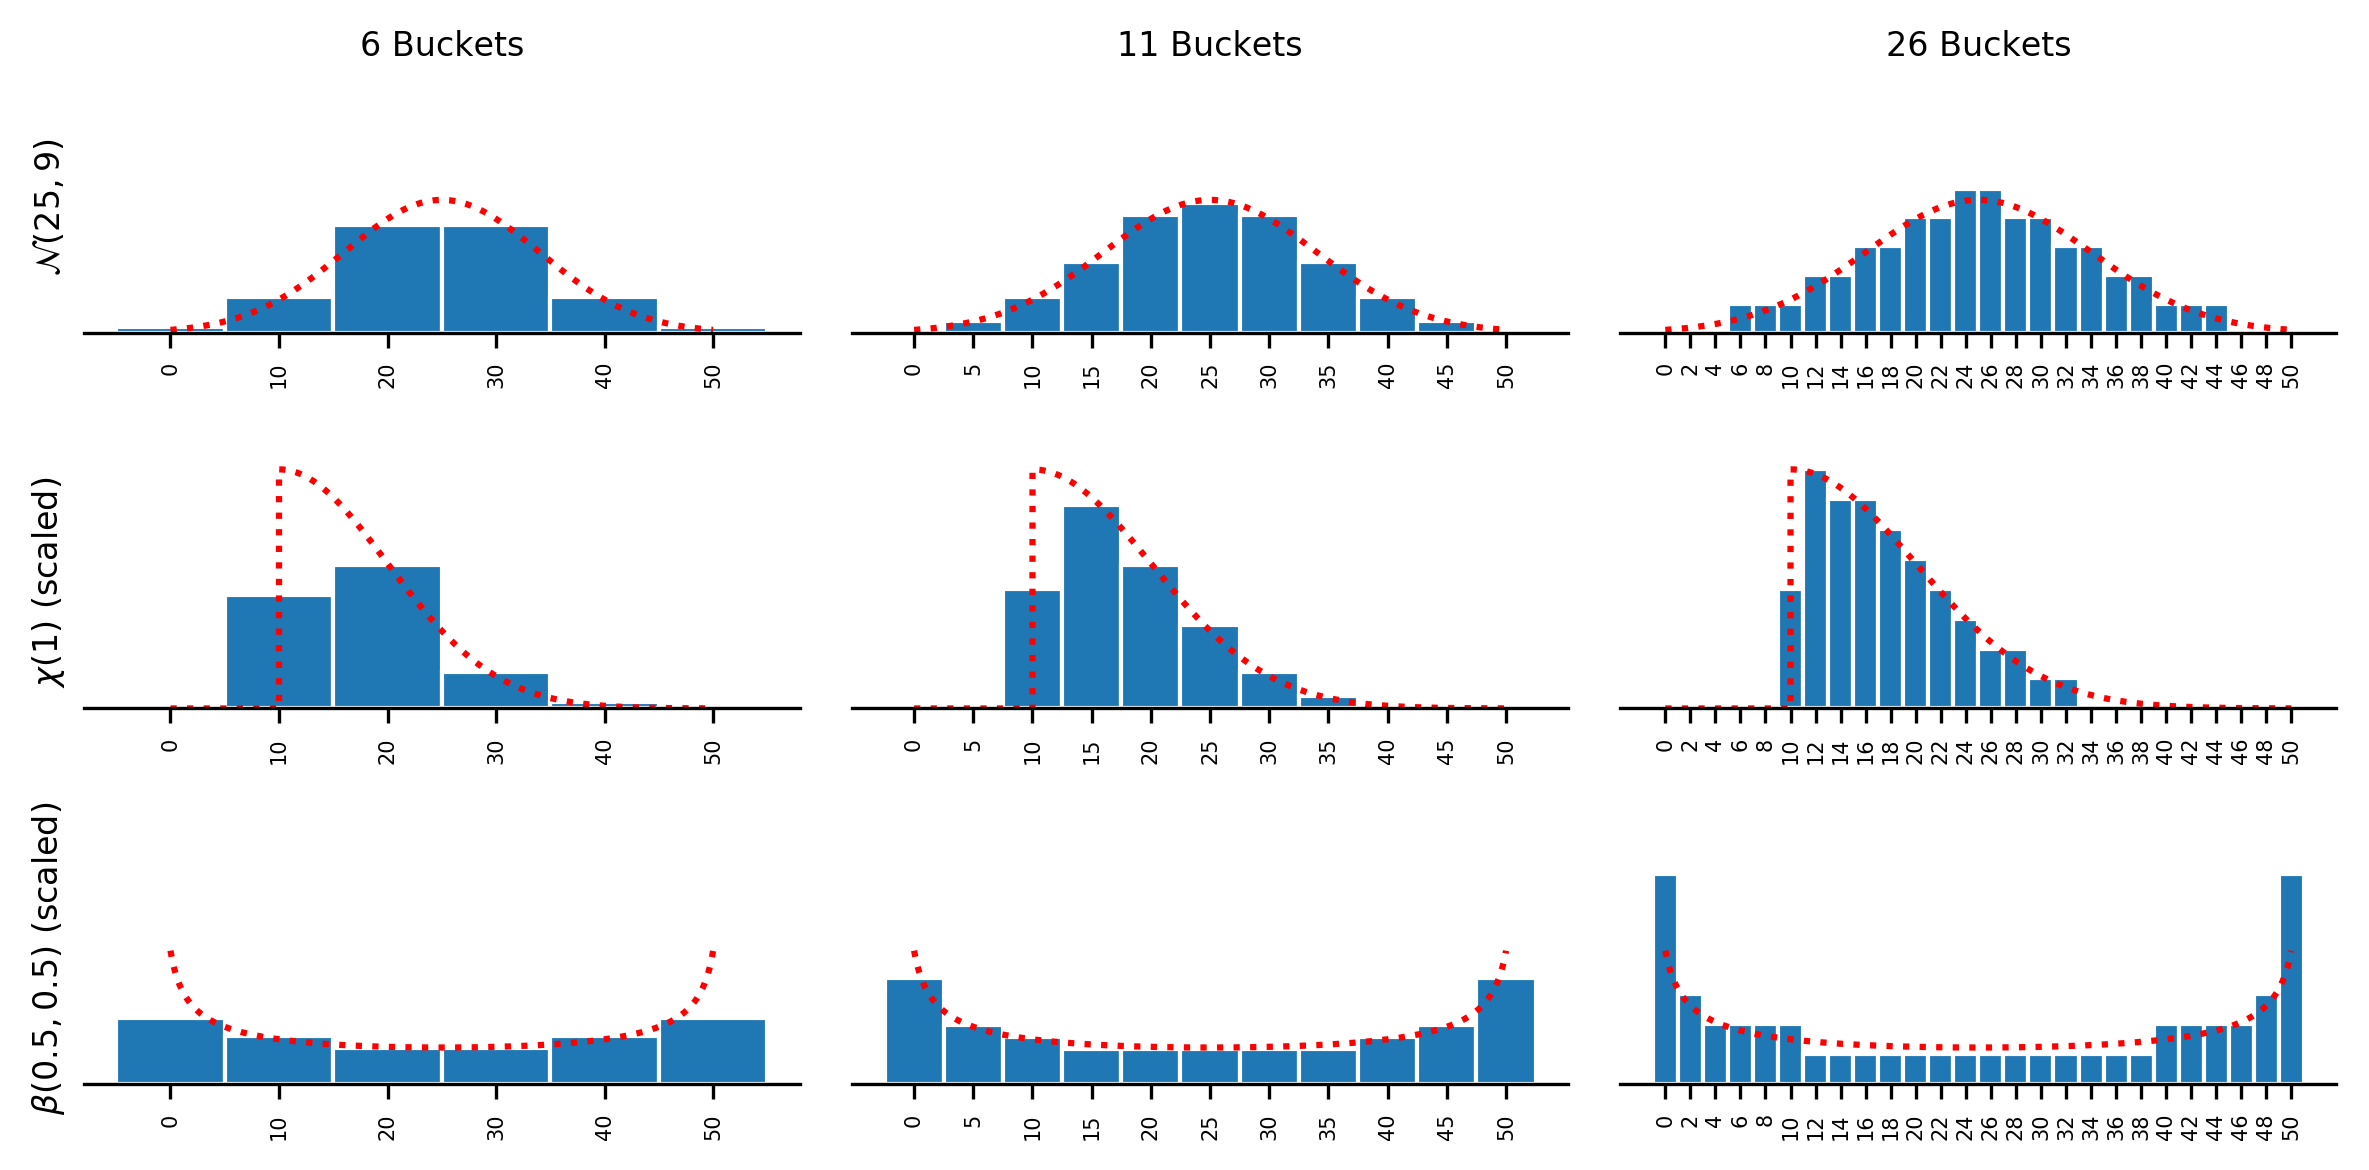

In [17]:
# Normal, Chi and Beta distributions.
dists = [stats.norm(25, 9), stats.chi(1, 10, 10), stats.beta(0.5, 0.5, -1, 52)]

# 6, 11 and 26 buckets.
buckets = [np.arange(0, 51, 10),  np.arange(0, 51, 5), np.arange(0, 51, 2)]

# Corresponding bins and widths
bins = [np.arange(-5, 56, 10), np.arange(-2.5, 53.5, 5), np.arange(-1, 52, 2)]
widths = [10, 5, 2]

r = np.arange(0, 50, 0.001)
fig, axes = plt.subplots(3, 3, figsize=(8, 4), sharey=True, dpi=300)
for i, ax in enumerate(axes):
    for j, a in enumerate(ax):
        d = dists[i]
        balls = bin_dist(d, buckets[j], 50)
        a.hist(balls, bins=bins[j], width=widths[j], align="mid", rwidth=1, density=True, ec="white")
        a.plot(r, d.pdf(r), ls=":", color="red")

        sns.despine(left=True)
        a.set_yticks([])
        a.set_xticks(buckets[j])
        a.tick_params(axis="x", labelrotation=90, labelsize=5)
        a.tick_params(axis="y", labelrotation=0, labelsize=5)
        
for a, t in zip(axes, [r"$\mathcal{N}(25, 9)$", r"$\chi(1)$ (scaled)", r"$\beta(0.5, 0.5)$ (scaled)"]):
    a[0].set_ylabel("{}".format(t), size=8)
    
for a, t in zip(axes[0], ["6", "11", "26"]):
    a.set_title("{} Buckets".format(t), size=8)
    
plt.tight_layout()

A few rules to finish:
* Don't use too few buckets. The larger your buckets are, the less faithful the representation of the distribution will be.
* Don't present too few observations. You also need a good number of them to faithfully represent the distribution.
* Make sure that your buckets cover the "full" distribution: your distribution should have support on all buckets, and the buckets should cover the majority of the support of the distribution.